<a href="https://colab.research.google.com/github/goshan16389/ii_ubiet_mir/blob/main/1task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка необходимых библиотек
!pip install tensorflow>=2.10
!pip install tensorflow-datasets

In [ ]:
# Установка необходимых библиотек
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Загрузка датасета PlantVillage и разбиение на обучающую, валидационную и тестовую выборки
 (ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes  # 38
print(f"Количество классов: {NUM_CLASSES}")

Количество классов: 38


In [ ]:
# Задание целевого размера изображений
IMG_SIZE = 224

#Предобработка изображений (нормализация)
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# Аугментация данных для обучающей выборки
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Настройка параметров загрузки данных
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Подготовка обучающей выборки: предобработка, аугментация, перемешивание, батчинг
train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Подготовка валидационной и тестовой выборок (без аугментации)
val_ds = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
# Загрузка предобученной EfficientNetB0
base = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base.trainable = False

# Построение классификационной модели
model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Определение callback-функций для ранней остановки и адаптивного learning rate
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,387,273 (16.74 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Обучение модели
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)




Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3622s 3s/step - accuracy: 0.7532 - loss: 0.9110 - val_accuracy: 0.9372 - val_loss: 0.1890 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3561s 3s/step - accuracy: 0.9205 - loss: 0.2439 - val_accuracy: 0.9328 - val_loss: 0.2009 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3743s 3s/step - accuracy: 0.9376 - loss: 0.1902 - val_accuracy: 0.9543 - val_loss: 0.1381 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3621s 3s/step - accuracy: 0.9409 - loss: 0.1707 - val_accuracy: 0.9588 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3561s 3s/step - accuracy: 0.9496 - loss: 0.1527 - val_accuracy: 0.9575 - val_loss: 0.1272 - learning_rate: 0.0010


In [ ]:
# Сохранение обученной модели
model.save('plantvillage.keras')

In [ ]:
# Оценка качества модели на тестовой выборке
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Сбор предсказаний для confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())


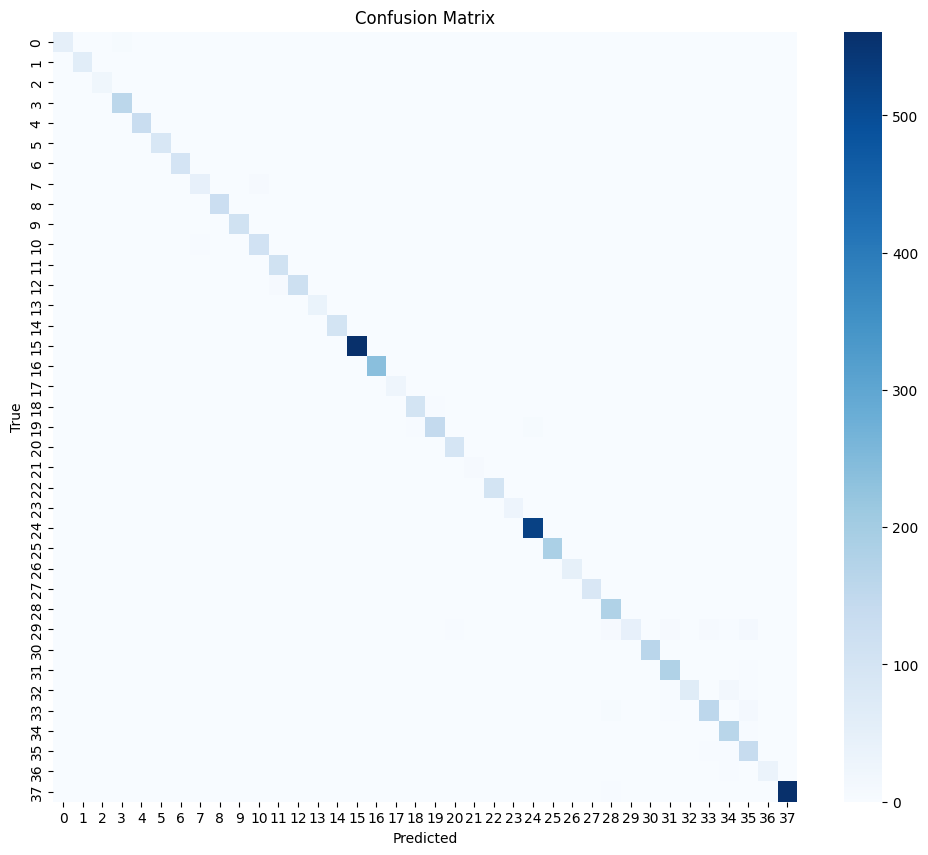

In [ ]:
# Построение confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=ds_info.features['label'].names, yticklabels=ds_info.features['label'].names)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()


                                               precision    recall  f1-score   support

                           Apple___Apple_scab      0.945     0.897     0.920        58
                            Apple___Black_rot      1.000     0.954     0.976        65
                     Apple___Cedar_apple_rust      1.000     0.920     0.958        25
                              Apple___healthy      0.952     0.994     0.972       159
                          Blueberry___healthy      1.000     1.000     1.000       133
                             Cherry___healthy      1.000     0.989     0.994        90
                      Cherry___Powdery_mildew      0.990     0.990     0.990       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot      0.906     0.857     0.881        56
                           Corn___Common_rust      1.000     0.984     0.992       127
                               Corn___healthy      1.000     0.991     0.996       112
                  Corn___Northern_Leaf_Bli

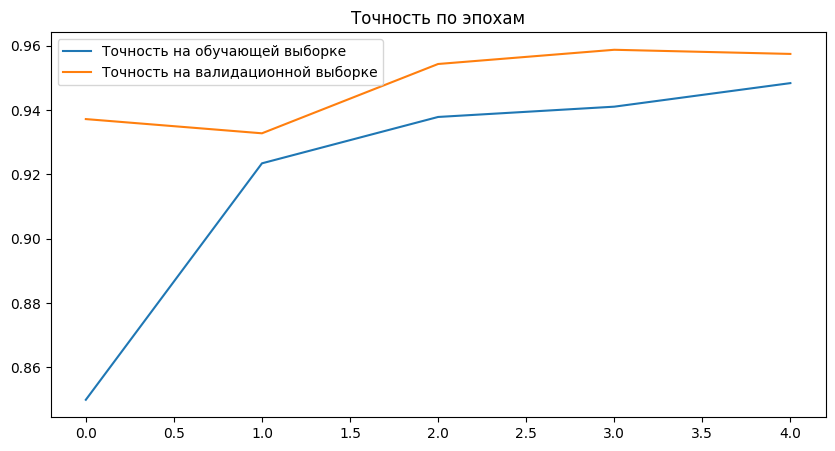

In [ ]:
# Формирование текстового отчёта по классификации
report = classification_report(y_true, y_pred, target_names=ds_info.features['label'].names, digits=3)
print(report)

with open('model_report.txt', 'w') as f:
    f.write(f"Точность на тестовой выборке: {test_acc:.4f}\n\n")
    f.write(report)

# Визуализация процесса обучения (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label='Точность на валидационной выборке')
plt.legend()
plt.title('Точность по эпохам')
plt.savefig('training_history.png')
plt.show()

In [ ]:
from google.colab import files

files.download('plantvillage.keras')
files.download('model_report.txt')
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving plantvillage.keras to plantvillage.keras


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('plantvillage.keras')